In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sys import float_info # Threshold smallest positive floating value


priors = np.array([0.65, 0.35])
weights = np.array([.5, .5])
class0_mean = np.array([[3,0],[0,3]])
class0_cov = np.array([[[2,0],[0,1]],[[1,0],[0,2]]])
class1_mean = np.array([2,2])
class1_cov = np.array([[1,0],[0,1]])

In [59]:
def generateData(numsamples):
    labels = np.where(np.random.rand(numsamples) >= .65, 1, 0)    
    data = np.empty((numsamples,2))

    for i in range(numsamples):
        if(labels[i] == 1):
            data[i] = np.random.multivariate_normal(class1_mean, class1_cov)
        else:
            rand = np.random.rand()
            subclass = 1 if rand>weights[0] else 0
            data[i] = np.random.multivariate_normal(class0_mean[subclass], class0_cov[subclass])
           
    return data, labels

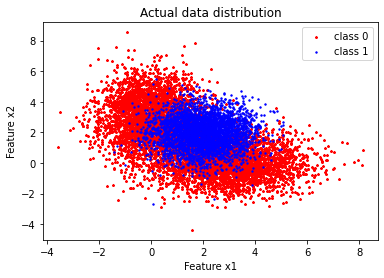

In [62]:
D20_train_data, D20_train_labels = generateData(20)
D200_train_data, D200_train_labels = generateData(200)
D2000_train_data, D2000_train_labels = generateData(2000)
D10k_validate_data, D10k_validate_labels = generateData(10000)

# I added below to plot the raw data
X = D10k_validate_data
labels = D10k_validate_labels
samples = 10000

# x0 = [i for i in range(0,samples) if(labels[i] == 0)]
# x1 = [i for i in range(0,samples) if(labels[i] == 1)]
plt.scatter(X[labels==0,0],X[labels==0,1],s=5, color = 'red', label = 'class 0',marker='*')
plt.scatter(X[labels==1,0],X[labels==1,1],s=2, color = 'blue', label = 'class 1',marker='o')
plt.title("Actual data distribution")
plt.xlabel("Feature x1")
plt.ylabel("Feature x2")
plt.legend()


(2, 10000)


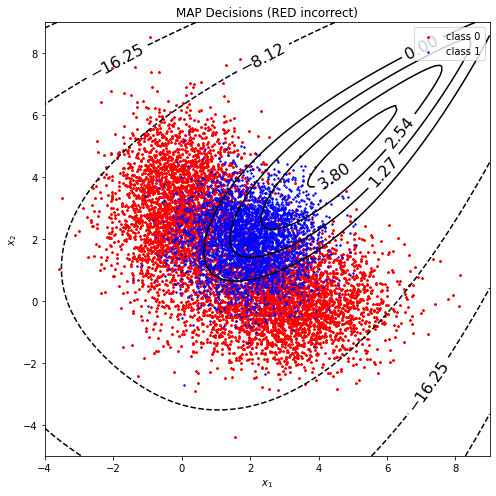

In [64]:
labels = D10k_validate_labels
samples = 10000

fig_disc_grid, ax_disc = plt.subplots(figsize=(7, 7));
# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.scatter(X[labels==0,0],X[labels==0,1],s=5, color = 'red', label = 'class 0',marker='*')
ax_disc.scatter(X[labels==1,0],X[labels==1,1],s=2, color = 'blue', label = 'class 1',marker='o')

ax_disc.legend();
ax_disc.set_xlabel(r"$x_1$");
ax_disc.set_ylabel(r"$x_2$");
ax_disc.set_title("MAP Decisions (RED incorrect)");
fig_disc_grid.tight_layout();


# Plot IDEAL contours
horizontal_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])

class0_condprob_ = weights[0]*multivariate_normal.pdf(gridxy.T, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(gridxy.T, class0_mean[1], class0_cov[1])
class1_condprob_ = multivariate_normal.pdf(gridxy.T, class1_mean, class1_cov)

likelihood_grid_vals = np.array([class0_condprob_, class1_condprob_])
# Where a score of 0 indicates decision boundary level
print(likelihood_grid_vals.shape)
gamma_map = priors[0]/priors[1]
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

plt.show()
fig_disc_grid;

In [19]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1))) #~[6500,3500]

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    # These are all the possible values of Gamma that we will test through
    taus = ([sorted_score[0] - float_info.epsilon] + sorted_score +
             [sorted_score[-1] + float_info.epsilon])
        
    # Calculate the decision label for each observation for each gamma [10000]
    decisions = [discriminant_score >= t for t in taus]

    # True Positive
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]
    # False Positive
    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    
    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    # Calculate error probability
    prob_error = [(p10[w] *priors[0] + (1 - p11[w])* priors[1]) for w in range(len(p10))]

    return roc, taus, prob_error

In [22]:
x = D10k_validate_data
labels = D10k_validate_labels

# Class conditional likelihood is a 2x10,000 matrix of likelihoods for each sample based on gaussian distribution
ccl0 = weights[0]*multivariate_normal.pdf(x, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(x, class0_mean[1], class0_cov[1])
ccl1 = multivariate_normal.pdf(x, class1_mean, class1_cov)
class_conditional_likelihoods = np.array([ccl0, ccl1])

# Discriminant Score using log-likelihood ratio: is a 10,000-length vector of values to compare to the threshold
discriminant_score = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Vary Gamma gradually and compute True-Positive and False-Positive probabilities
roc_erm, tau, prob_error = estimate_roc(discriminant_score, labels)

# Find minimum error and index
minimum_error = min(prob_error)
minimum_index = prob_error.index(minimum_error)

# Experimental / approximate Threshold Gamma value
# e^ (undo log in prev cell)
gamma_approx = np.exp(tau[minimum_index])
print("Approximated Threshold: ", gamma_approx)
print("Approximated Minimum Error: ", minimum_error)

gamma_th = priors[0]/priors[1]
# Same as: gamma_th = priors[0]/priors[1]
print("Theoretical Gamma / Threshold = ", gamma_th)

# get decision for EACH sample based on theoretically optimal threshold
decisions_map = discriminant_score >= np.log(gamma_th)


# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nlabels[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nlabels[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nlabels[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nlabels[1]

# Theoretical 
roc_map = np.array((p_10_map, p_11_map))

# Probability of error for MAP classifier, empirically estimated
prob_error_th = (p_10_map *priors[0] + (1 - p_11_map)* priors[1])
print("Theoretical Minimum Error: ", prob_error_th)




Approximated Threshold:  2.1845744194278227
Approximated Minimum Error:  0.17350078816273906
Theoretical Gamma / Threshold =  1.8571428571428574
Theoretical Minimum Error:  0.1757885623366102


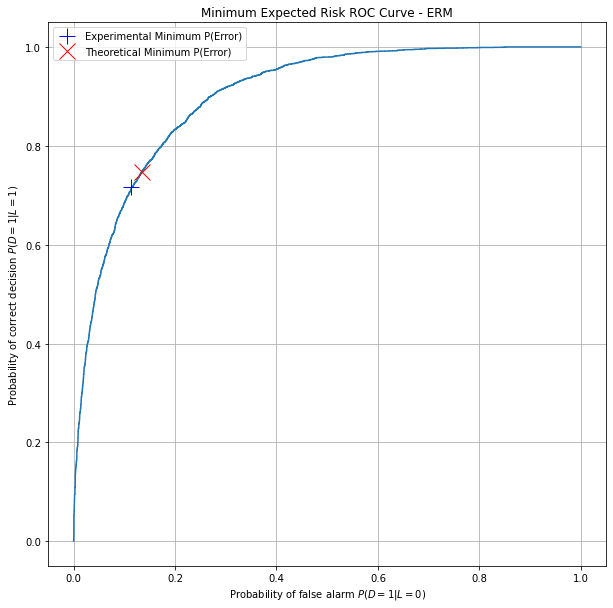

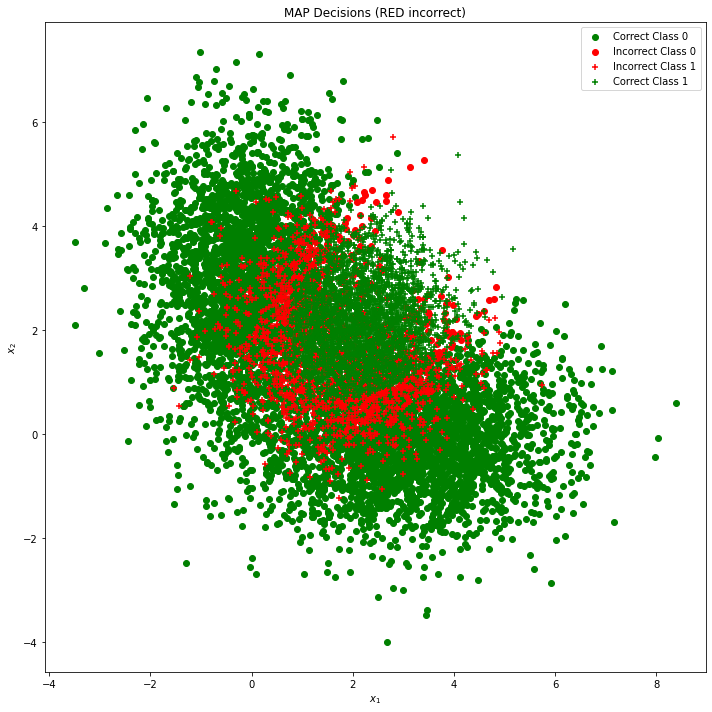

In [55]:
# Plot ROC
fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_erm[0,minimum_index], roc_erm[1,minimum_index],'b+', label="Experimental Minimum P(Error)", markersize=16)
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Theoretical Minimum P(Error)", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.title("Minimum Expected Risk ROC Curve - ERM")
plt.grid(True)

fig_roc;


# Display MAP decisions
fig, ax4 = plt.subplots(figsize=(10, 10))

# class 0 circle, class 1 +, correct green, incorrect red
ax4.scatter(x[ind_00_map, 0], x[ind_00_map, 1], c='g',marker='o', label="Correct Class 0")
ax4.scatter(x[ind_10_map, 0], x[ind_10_map, 1],c='r',marker='o', label="Incorrect Class 0")
ax4.scatter(x[ind_01_map, 0], x[ind_01_map, 1], c='r',marker='+', label="Incorrect Class 1")
ax4.scatter(x[ind_11_map, 0], x[ind_11_map, 1], c='g',marker='+', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MAP Decisions (RED incorrect)")
plt.tight_layout()
plt.show()
fig;

(2, 10000)


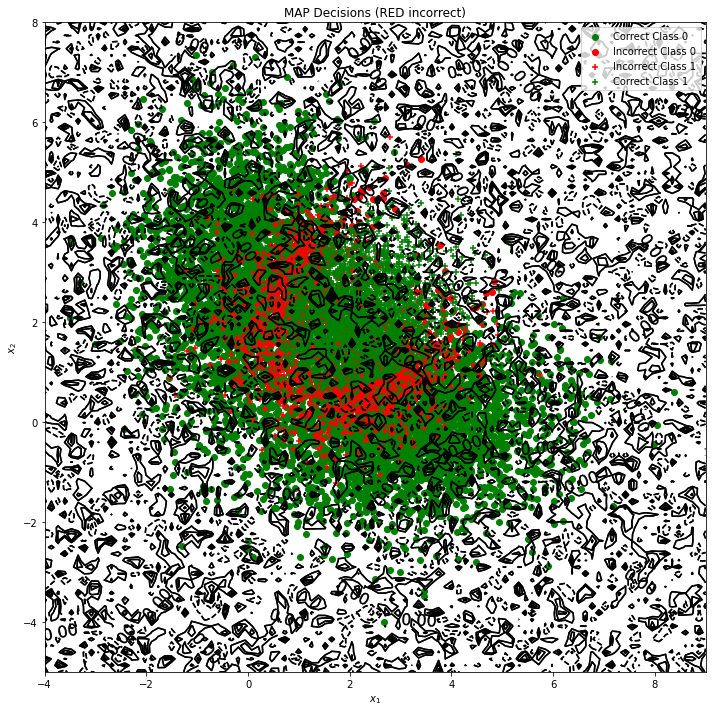

In [57]:
# Plot IDEAL contours
horizontal_grid = np.linspace(np.floor(np.min(x[:,0])), np.ceil(np.max(x[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(x[:,1])), np.ceil(np.max(x[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])

# Class conditional likelihood is a 2x10,000 matrix of likelihoods for each sample based on gaussian distribution
ccl0 = weights[0]*multivariate_normal.pdf(gridxy.T, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(gridxy.T, class0_mean[1], class0_cov[1])
ccl1 = multivariate_normal.pdf(gridxy.T, class1_mean, class1_cov)
class_conditional_likelihoods = np.array([ccl0, ccl1])

likelihood_grid_vals = class_conditional_likelihoods
# Where a score of 0 indicates decision boundary level
print(likelihood_grid_vals.shape)
gamma_map = priors[0]/priors[1]
discriminant_score_grid_vals = discriminant_score- np.log(gamma_map)
#np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax4.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax4.clabel(cs, fontsize=16, inline=1)

plt.show()
fig

(2, 10000)


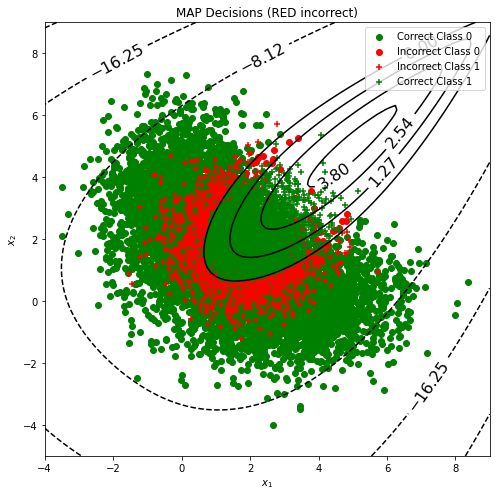

In [69]:
X = D10k_validate_data
labels = D10k_validate_labels
samples = 10000

fig_disc_grid, ax_disc = plt.subplots(figsize=(7, 7));
# class 0 circle, class 1 +, correct green, incorrect red
# ax_disc.scatter(X[labels==0,0],X[labels==0,1],s=5, color = 'red', label = 'class 0',marker='*')
# ax_disc.scatter(X[labels==1,0],X[labels==1,1],s=2, color = 'blue', label = 'class 1',marker='o')
# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.scatter(x[ind_00_map, 0], x[ind_00_map, 1], c='g',marker='o', label="Correct Class 0")
ax_disc.scatter(x[ind_10_map, 0], x[ind_10_map, 1],c='r',marker='o', label="Incorrect Class 0")
ax_disc.scatter(x[ind_01_map, 0], x[ind_01_map, 1], c='r',marker='+', label="Incorrect Class 1")
ax_disc.scatter(x[ind_11_map, 0], x[ind_11_map, 1], c='g',marker='+', label="Correct Class 1")

ax_disc.legend();
ax_disc.set_xlabel(r"$x_1$");
ax_disc.set_ylabel(r"$x_2$");
ax_disc.set_title("MAP Decisions (RED incorrect)");
fig_disc_grid.tight_layout();


# Plot IDEAL contours
horizontal_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])

ccl0 = weights[0]*multivariate_normal.pdf(gridxy.T, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(gridxy.T, class0_mean[1], class0_cov[1])
ccl1 = multivariate_normal.pdf(gridxy.T, class1_mean, class1_cov)
likelihood_grid_vals = np.array([ccl0, ccl1])

# Where a score of 0 indicates decision boundary level
print(likelihood_grid_vals.shape)
gamma_map = priors[0]/priors[1]
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

#plt.show()
fig_disc_grid;